<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day21_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
print('Setup complete')

Setup complete


In [2]:
!pip install xgboost lightgbm catboost -q
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00



## : Bagging vs Boosting

| Aspect | Bagging (RF) | Boosting (GBM) |
|--------|--------------|----------------|
| Training | Parallel (independent trees) | Sequential (each fixes previous errors) |
| Samples | Bootstrap (random) | Weighted (focus on mistakes) |
| Trees | Full depth, averaged | Shallow, added together |
| Bias-Variance | Reduces variance | Reduces bias |
| Overfitting | Resistant | Can overfit (needs tuning) |

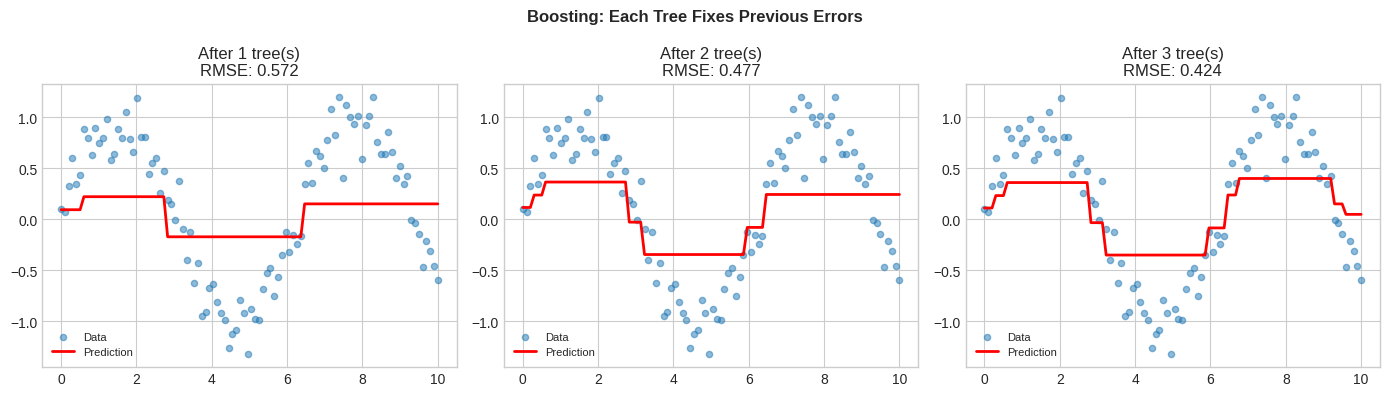

In [3]:
#%%
# Visual: Boosting builds sequentially
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

np.random.seed(42)
X_demo = np.linspace(0, 10, 100).reshape(-1, 1)
y_demo = np.sin(X_demo).ravel() + np.random.normal(0, 0.2, 100)

# Simulate boosting iterations
residuals = y_demo.copy()
predictions = np.zeros_like(y_demo)

for i, ax in enumerate(axes):
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X_demo, residuals)
    pred = tree.predict(X_demo)
    predictions += 0.3 * pred  # learning rate = 0.3
    residuals = y_demo - predictions

    ax.scatter(X_demo, y_demo, alpha=0.5, s=20, label='Data')
    ax.plot(X_demo, predictions, 'r-', linewidth=2, label='Prediction')
    ax.set_title(f'After {i+1} tree(s)\nRMSE: {np.sqrt(np.mean(residuals**2)):.3f}')
    ax.legend(fontsize=8)

plt.suptitle('Boosting: Each Tree Fixes Previous Errors', fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
housing = fetch_california_housing()
x = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print(f"{x.shape[0]:,} samples, {x.shape[1]} features")
print(f"Target: Median house value ($100k)")
print(f"Features: {list(x.columns)}")

20,640 samples, 8 features
Target: Median house value ($100k)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
x.describe().round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Train: {len(x_train):,}, Test: {len(x_test):,}")

Train: 16,512, Test: 4,128


In [7]:
def evaluate(model, x_tr, y_tr, x_te, y_te):
  """ Quick evaluation helper"""
  train_pred = model.predict(x_tr)
  test_pred = model.predict(x_te)
  return {
      'Train RMSE': np.sqrt(mean_squared_error(y_tr, train_pred)),
      'Test RMSE': np.sqrt(mean_squared_error(y_te, test_pred)),
      'Train MAE': mean_absolute_error(y_tr, train_pred),
      'Test MAE': mean_absolute_error(y_te, test_pred),\
      'Train R2': r2_score(y_tr, train_pred),
      'Test R2': r2_score(y_te, test_pred)
  }

In [8]:
#Single Tree
tree = DecisionTreeRegressor(random_state=42)
tree.fit(x_train, y_train)
tree_results = evaluate(tree, x_train, y_train, x_test, y_test)

#Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
rf_results = evaluate(rf, x_train, y_train, x_test, y_test)

print("Baselines: ")
print(f"{'Model':<20} {'Train RMSE':<12} {'Test RMSE':<12} {'Test R2':<10}")
print("-"*55)
print(f"{'Single Tree':<20} {tree_results['Train RMSE']:<12.4f} {tree_results['Test RMSE']:<12.4f} {tree_results['Test R2']:<10.4f}")
print(f"{'Random Forest':<20} {rf_results['Train RMSE']:<12.4f} {rf_results['Test RMSE']:<12.4f} {rf_results['Test R2']:<10.4f}")

Baselines: 
Model                Train RMSE   Test RMSE    Test R2   
-------------------------------------------------------
Single Tree          0.0000       0.7037       0.6221    
Random Forest        0.1880       0.5053       0.8051    


In [9]:
# Sklearn Boosting Regressor
gbm = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(x_train, y_train)
gbm_results = evaluate(gbm, x_train, y_train, x_test, y_test)

print("Gradient Boosting: ")
print(f"Test RMSE: {gbm_results['Test RMSE']:.4f}")
print(f"Test R2: {gbm_results['Test R2']:.4f}")

Gradient Boosting: 
Test RMSE: 0.5422
Test R2: 0.7756


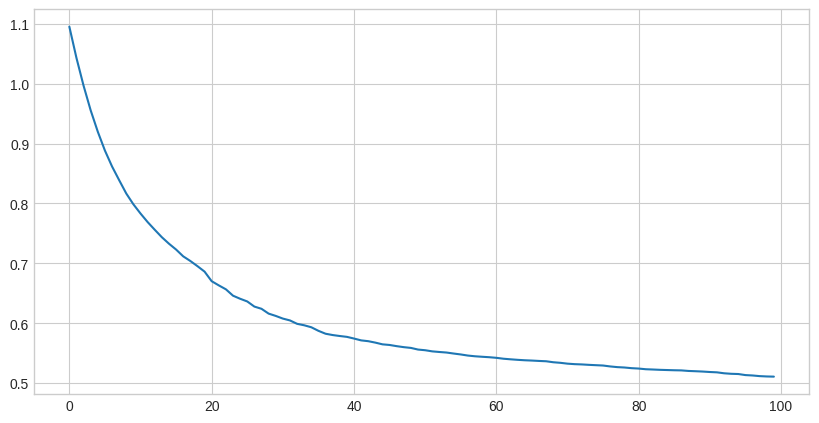

In [10]:
# Learning Curve
train_scores = []
test_scores = []

for i, y_pred in enumerate(gbm.staged_predict(x_train)):
  train_scores.append(np.sqrt(mean_squared_error(y_train, y_pred)))

for i, y_pred in enumerate(gbm.staged_predict(x_test)):
  test_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

plt.figure(figsize=(10, 5))
plt.plot(train_scores,, 'b-', label='Train RMSE')
plt.plot(test_scores, 'r-', label='Test RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best Test RMSE: {np.min(test_scores):.4f}")

Learning Rate vs N_estimators

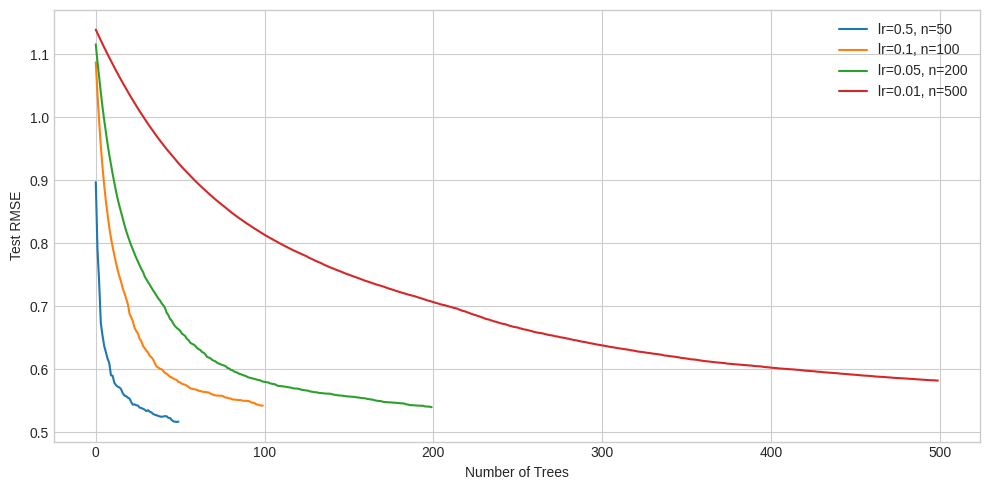

In [11]:
#The tradeoff is that a lower learning rate needs more trees
configs = [
    (0.5, 50),
    (0.1, 100),
    (0.05, 200),
    (0.01, 500),
]

plt.figure(figsize=(10, 5))

for lr, n_est in configs:
  gbm_temp = GradientBoostingRegressor(n_estimators=n_est, learning_rate=lr, random_state=42, max_depth=3)
  gbm_temp.fit(x_train, y_train)
  test_scores = [np.sqrt(mean_squared_error(y_test, pred)) for pred in gbm_temp.staged_predict(x_test)]
  plt.plot(test_scores, label=f'lr={lr}, n={n_est}')

plt.xlabel('Number of Trees')
plt.ylabel('Test RMSE')
plt.legend()
plt.tight_layout()
plt.show()


XGBoost

In [12]:
# Extreme Gradient Boosting
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(x_train, y_train)
xgb_results = evaluate(xgb_model, x_train, y_train, x_test, y_test)

print(f"Test RMSE: {xgb_results['Test RMSE']:.4f}")
print(f"Test R2: {xgb_results['Test R2']:.4f}")

Test RMSE: 0.5433
Test R2: 0.7747


In [15]:
#With early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20
)

xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

print(f"Best Iteration: {xgb_model.best_iteration}")
print(f"Best Score: {xgb_model.best_score:.4f}")
print(f"Test RMSE: {xgb_results['Test RMSE']:.4f}")


Best Iteration: 999
Best Score: 0.4660
Test RMSE: 0.5433


LightGBM

In [17]:
# Light Gradient Boosting Machine
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(x_train, y_train)
lgb_results = evaluate(lgb_model, x_train, y_train, x_test, y_test)

print(f"Test RMSE: {lgb_results['Test RMSE']:.4f}")
print(f"Test R2: {lgb_results['Test R2']:.4f}")


Test RMSE: 0.5380
Test R2: 0.7792


CatBoost

In [18]:
# Categorical Boosting
cat_model = CatBoostRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    verbose=0
)

cat_model.fit(x_train, y_train)
cat_results = evaluate(cat_model, x_train, y_train, x_test, y_test)

print(f"Test RMSE: {cat_results['Test RMSE']:.4f}")
print(f"Test R2: {cat_results['Test R2']:.4f}")

Test RMSE: 0.5704
Test R2: 0.7517


Comparison

In [19]:
#Comparing all the models
results = {
    'Single Tree': tree_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gbm_results,
    'XGBoost': xgb_results,
    'LightGBM': lgb_results,
    'CatBoost': cat_results
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test RMSE')

print(results_df.round(4).to_string())

                   Train RMSE  Test RMSE  Train MAE  Test MAE  Train R2  Test R2
Random Forest          0.1880     0.5053     0.1221    0.3275    0.9736   0.8051
LightGBM               0.5111     0.5380     0.3546    0.3666    0.8046   0.7792
Gradient Boosting      0.5107     0.5422     0.3566    0.3716    0.8049   0.7756
XGBoost                0.5154     0.5433     0.3591    0.3710    0.8013   0.7747
CatBoost               0.5510     0.5704     0.3872    0.3952    0.7729   0.7517
Single Tree            0.0000     0.7037     0.0000    0.4547    1.0000   0.6221


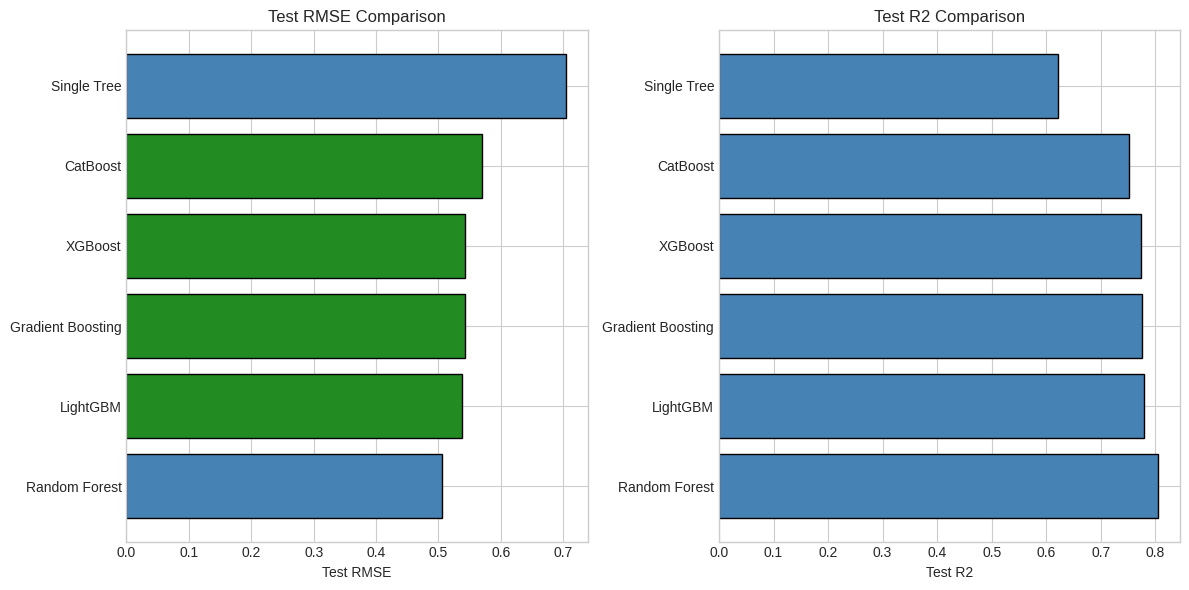

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#RMSE
colors = ['forestgreen' if 'Boost' in m or 'XG' in m or 'Light' in m or
          'Cat' in m else 'steelblue' for m in results_df.index]
axes[0].barh(results_df.index, results_df['Test RMSE'], color=colors, edgecolor='black')
axes[0].set_xlabel("Test RMSE")
axes[0].set_title('Test RMSE Comparison')

#R2
axes[1].barh(results_df.index, results_df['Test R2'], color='steelblue', edgecolor='black')
axes[1].set_xlabel("Test R2")
axes[1].set_title("Test R2 Comparison")

plt.tight_layout()
plt.show()

#Green = Boostin, Blue = Other

Feature Importance

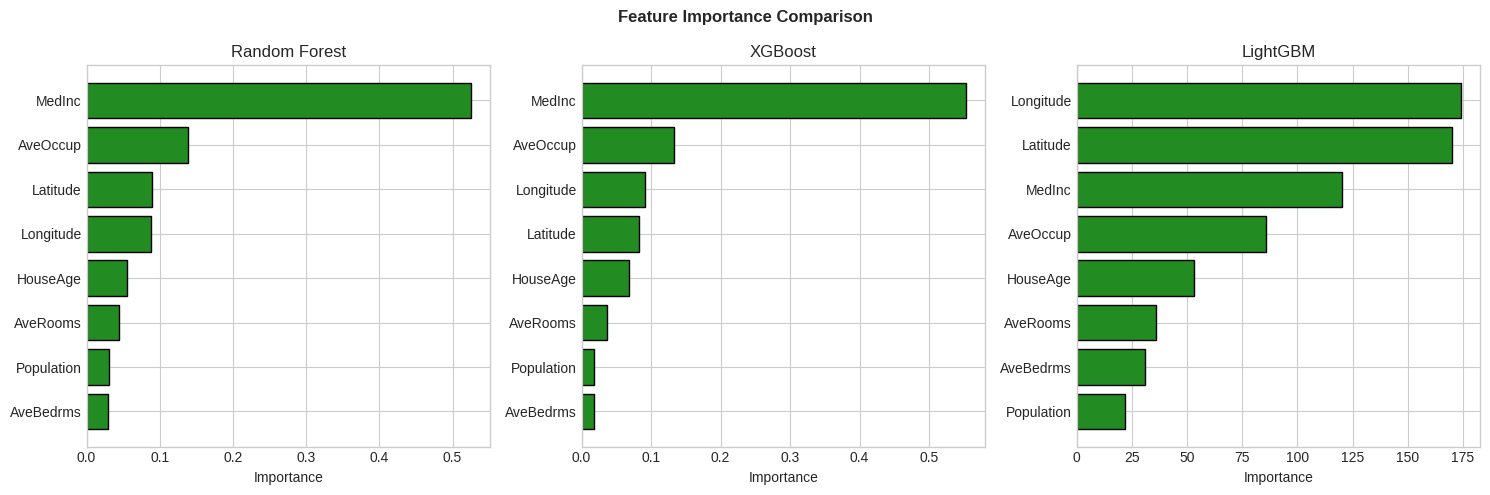

In [22]:
#%%
# Compare feature importance across models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_fi = [
    ('Random Forest', rf.feature_importances_),
    ('XGBoost', xgb_model.feature_importances_),
    ('LightGBM', lgb_model.feature_importances_)
]

for ax, (name, importance) in zip(axes, models_fi):
    sorted_idx = np.argsort(importance)
    ax.barh(range(len(importance)), importance[sorted_idx], color='forestgreen', edgecolor='black')
    ax.set_yticks(range(len(importance)))
    ax.set_yticklabels(np.array(x.columns)[sorted_idx])
    ax.set_xlabel('Importance')
    ax.set_title(name)

plt.suptitle('Feature Importance Comparison', fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
#%%
# Quick grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1
)
grid_search.fit(x_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, grid_search.predict(x_test))):.4f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.8}
Best CV RMSE: 0.4719
Test RMSE: 0.4664



## Summary

### Boosting vs Bagging

| Aspect | Random Forest | Gradient Boosting |
|--------|---------------|-------------------|
| Training | Parallel | Sequential |
| Trees | Deep, independent | Shallow, dependent |
| Overfitting | Resistant | Needs tuning |
| Speed | Fast (parallel) | Slower (sequential) |

### Popular Libraries

| Library | Strengths |
|---------|----------|
| XGBoost | Fast, regularization, widely used |
| LightGBM | Fastest, handles large data |
| CatBoost | Best for categorical features |

### Key Hyperparameters

| Parameter | Effect |
|-----------|--------|
| learning_rate | Lower = more trees needed, often better |
| n_estimators | More = better (use early stopping) |
| max_depth | Lower than RF (3-7 typical) |
| subsample | <1.0 reduces overfitting |

### Best Practices
1. Start with default parameters
2. Use early stopping
3. Lower learning rate + more trees
4. Tune max_depth first